In [61]:
import pandas as pd
import numpy as np
import perception.util.conversion as conv
import os
import cv2
import scipy
import math
import seaborn as sns
import importlib
import statsmodels.api as sm
import pickle
import ground_truth_real

from toleranceinterval import twoside
from ground_truth_real import GroundTruthMeasurements
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.interpolate import UnivariateSpline
from collections import defaultdict
from scipy.stats import normaltest
from typing import Literal

from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import PchipInterpolator

plt.style.use("seaborn-v0_8")
sns.set_palette(sns.color_palette("colorblind"))

### Import and process BEV and tracking poses

In [2]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
figures_dir = f'{os.getcwd()}/../../../../figures'
run1_path = f'{experiments_dir}/run1'
run2_path = f'{experiments_dir}/run2'
run3_path = f'{experiments_dir}/run3'

bev_paths_run1 = [f'{run1_path}/bev/{f}' for f in os.listdir(f'{run1_path}/bev') if os.path.isdir(f'{run1_path}/bev/{f}')]
bev_paths_run2 = [f'{run2_path}/bev/{f}' for f in os.listdir(f'{run2_path}/bev') if os.path.isdir(f'{run2_path}/bev/{f}')]
bev_paths_run3 = [f'{run3_path}/bev/{f}' for f in os.listdir(f'{run3_path}/bev') if os.path.isdir(f'{run3_path}/bev/{f}')]

tracking_paths_run1 = [f'{run1_path}/ego/{f}/color' for f in os.listdir(f'{run1_path}/ego') if os.path.isdir(f'{run1_path}/ego/{f}')]
tracking_paths_run2 = [f'{run2_path}/ego/{f}/color' for f in os.listdir(f'{run2_path}/ego') if os.path.isdir(f'{run2_path}/ego/{f}')]
tracking_paths_run3 = [f'{run3_path}/ego/{f}/color' for f in os.listdir(f'{run3_path}/ego') if os.path.isdir(f'{run3_path}/ego/{f}')]

RUN1_2_MEASUREMENTS = GroundTruthMeasurements(
  bev_to_cam_ego_x=-184.8,
  bev_to_cam_ego_y=-39.5,
  bev_to_cam_ego_z=12.5,
  bev_to_back_opp_x=-100.0,
  bev_to_back_opp_y=0.0,
  bev_to_back_opp_z=-120.0,
  ego_top_marker_to_ego_cam_rot=conv.get_rotation_matrix_from_euler(-90, 0, 90, degrees=True),
  opp_top_marker_to_opp_back_marker_rot=conv.get_rotation_matrix_from_euler(-90, 90, 90, degrees=True),
)

RUN3_MEASUREMENTS = GroundTruthMeasurements(
  bev_to_cam_ego_x=-28.7,
  bev_to_cam_ego_y=376.0,
  bev_to_cam_ego_z=-94.9,
  bev_to_back_opp_x=-157.0,
  bev_to_back_opp_y=0.0,
  bev_to_back_opp_z=-116.0,
  ego_top_marker_to_ego_cam_rot=conv.get_rotation_matrix_from_euler(-90, 0, 0, degrees=True),
  opp_top_marker_to_opp_back_marker_rot=conv.get_rotation_matrix_from_euler(-90, 90, 90, degrees=True),
)

k = twoside.normal_factor(1000, 0.95, 0.95)

In [3]:
importlib.reload(ground_truth_real)

<module 'ground_truth_real' from '/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/ground_truth_real.py'>

In [4]:
smoothing_funcs = ["lowess"]
run1_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run1, tracking_paths_run1), RUN1_2_MEASUREMENTS, smoothing_funcs)
run2_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run2, tracking_paths_run2), RUN1_2_MEASUREMENTS, smoothing_funcs)
run3_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run3, tracking_paths_run3), RUN3_MEASUREMENTS, smoothing_funcs)

### Show the dictionary structure

In [5]:
def extract_keys(nested_dict):
  if not isinstance(nested_dict, dict):
    return None
  
  return {key: extract_keys(value) for key, value in nested_dict.items()}

result = extract_keys(run1_data[0])
result

{'start_time': None,
 'bev_path': None,
 'ego_path': None,
 'raw': {'ego_bev_right_df': None,
  'opp_bev_right_df': None,
  'ego_bev_left_df': None,
  'opp_bev_left_df': None,
  'ego_avg_bev_df': None,
  'rel_poses_left_df': None,
  'rel_poses_right_df': None,
  'rel_poses_avg_df': None},
 'tracking_df': None,
 'monte_carlo_right_df': None,
 'monte_carlo_left_df': None,
 'kalman_ca_df': None,
 'kalman_cv_df': None,
 'rwr_df': None,
 'kalman_ca_depth_fusion_df': None,
 'monte_carlo_avg_df': None,
 'lowess': {'ego_bev_right_df': None,
  'opp_bev_right_df': None,
  'ego_bev_left_df': None,
  'opp_bev_left_df': None,
  'ego_avg_bev_df': None,
  'rel_poses_left_df': None,
  'rel_poses_right_df': None,
  'rel_poses_avg_df': None}}

In [6]:
side_length = 0.25
half_side_length = side_length / 2

# Define the 4 corners of the ArUco marker
marker_obj_points = np.array([[
    [-half_side_length, half_side_length, 0],
    [half_side_length, half_side_length, 0],
    [half_side_length, -half_side_length, 0],
    [-half_side_length, -half_side_length, 0]
]], dtype=np.float32)

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_APRILTAG

## Fit polynomial models to the BEV poses

In [7]:
class PolynomialParams:
  def __init__(self, df_name, x, y, degree):
    self.df_name = df_name
    self.x = x
    self.y = y
    self.degree = degree

def fit_polynomial_models(run_data, params: list[PolynomialParams], smoothing_type: str):
  for run in run_data:
    run[smoothing_type]["poly"] = {}

    for param in params:
      model, model_deriv, model_2nd_deriv = ground_truth_real.fit_polynomial(
        run[smoothing_type][param.df_name][param.x].values, 
        run[smoothing_type][param.df_name][param.y].values, param.degree)
      if param.df_name not in run[smoothing_type]["poly"]:
        run[smoothing_type]["poly"][param.df_name] = {}
      
      run[smoothing_type]["poly"][param.df_name][param.y] = (model, model_deriv, model_2nd_deriv)

poly_params = []

# Fit polynomial models for poses from BEV
for df_name in ["ego_bev_left_df", "ego_bev_right_df", "opp_bev_left_df", "opp_bev_right_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    if dim in ["tz", "roll", "pitch"]:
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", dim, 1))
    else:
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", dim, 12))

# Fit polynomial models for relative poses
for df_name in ["rel_poses_left_df", "rel_poses_right_df", "rel_poses_avg_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    if dim == "tz":
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", dim, 1))
    else:
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", dim, 12))

for smoothing_type in ["raw"] + smoothing_funcs:
  fit_polynomial_models(run1_data, poly_params, smoothing_type)
  fit_polynomial_models(run2_data, poly_params, smoothing_type)
  fit_polynomial_models(run3_data, poly_params, smoothing_type)

## Use PCHIP interpolation to interpolate the BEV poses

In [8]:
# import pchip interpolation
from scipy.interpolate import PchipInterpolator

class PchipParams:
  def __init__(self, df_name, x, y):
    self.df_name = df_name
    self.x = x
    self.y = y

def fit_pchip_interpolators(run_data, params: list[PchipParams], smoothing_type: str):
  for run in run_data:
    run[smoothing_type]["pchip"] = {}

    for param in params:
      model = PchipInterpolator(run[smoothing_type][param.df_name][param.x], run[smoothing_type][param.df_name][param.y])
      model_deriv = model.derivative()
      model_2nd_deriv = model.derivative(2)
      
      if param.df_name not in run[smoothing_type]["pchip"]:
        run[smoothing_type]["pchip"][param.df_name] = {}
      
      run[smoothing_type]["pchip"][param.df_name][param.y] = (model, model_deriv, model_2nd_deriv)

pchip_params = []

# Fit polynomial models for poses from BEV
for df_name in ["ego_bev_left_df", "ego_bev_right_df", "opp_bev_left_df", "opp_bev_right_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    pchip_params.append(PchipParams(df_name, "time_norm (sec)", dim))

# Fit polynomial models for relative poses
for df_name in ["rel_poses_left_df", "rel_poses_right_df", "rel_poses_avg_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    pchip_params.append(PchipParams(df_name, "time_norm (sec)", dim))

for smoothing_type in ["raw"] + smoothing_funcs:
  fit_pchip_interpolators(run1_data, pchip_params, smoothing_type)
  fit_pchip_interpolators(run2_data, pchip_params, smoothing_type)
  fit_pchip_interpolators(run3_data, pchip_params, smoothing_type)

## Fit UnivariateSpline (B-Spline) to interpolate the BEV poses

In [9]:
# spline params
class SplineParams:
  def __init__(self, df_name, x, y, degree=3, smoothing_factor=0):
    self.df_name = df_name
    self.x = x
    self.y = y
    self.degree = degree
    self.smoothing_factor = smoothing_factor

def fit_spline(run_data, smoothing_type: str):
  for run in run_data:
    run[smoothing_type]["spline"] = {}

    for df_name in ["ego_bev_left_df", "ego_bev_right_df", "opp_bev_left_df", "opp_bev_right_df"]:
      df = run[smoothing_type][df_name]
      for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
        if dim in ["roll", "pitch", "yaw"]:
          spline = UnivariateSpline(df["time_norm (sec)"], df[dim], k=3, s=0)
        else:
          spline = UnivariateSpline(df["time_norm (sec)"], df[dim], k=3, s=0)

        spline_deriv = spline.derivative()
        spline_2nd_deriv = spline_deriv.derivative()

        if df_name not in run[smoothing_type]["spline"]:
          run[smoothing_type]["spline"][df_name] = {}

        run[smoothing_type]["spline"][df_name][dim] = (spline, spline_deriv, spline_2nd_deriv)
      
    for df_name in ["rel_poses_left_df", "rel_poses_right_df", "rel_poses_avg_df"]:
      df = run[smoothing_type][df_name]
      for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
        if dim in ["roll", "pitch", "yaw"]:
          spline = UnivariateSpline(df["time_norm (sec)"], df[dim], k=3, s=0)
        else:
          spline = UnivariateSpline(df["time_norm (sec)"], df[dim], k=3, s=0)

        spline_deriv = spline.derivative()
        spline_2nd_deriv = spline_deriv.derivative()

        if df_name not in run[smoothing_type]["spline"]:
          run[smoothing_type]["spline"][df_name] = {}

        run[smoothing_type]["spline"][df_name][dim] = (spline, spline_deriv, spline_2nd_deriv)

for smoothing_type in ["raw"] + smoothing_funcs:
  fit_spline(run1_data, smoothing_type)
  fit_spline(run2_data, smoothing_type)
  fit_spline(run3_data, smoothing_type)

## Plot the displacement, velocity, and acceleration from the models

<AxesSubplot: xlabel='Time (s)', ylabel='Acceleration (m/s^2)'>

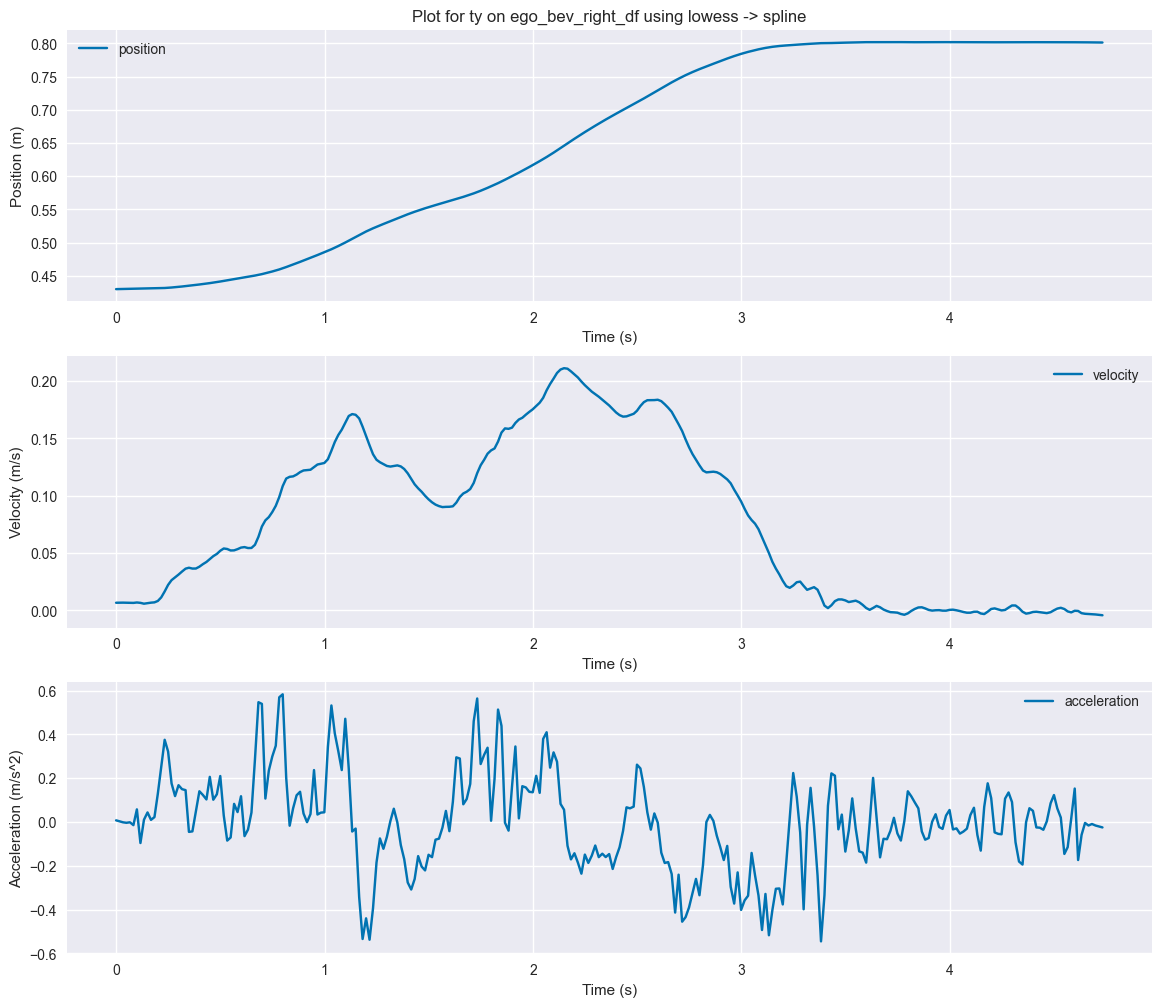

In [98]:
# Change these parameters to plot different data
smoothing_type = "lowess"
run_num = 6
run = run3_data[run_num][smoothing_type]
df_name = "ego_bev_right_df"
model_type = "spline"
y = "ty"

model, model_deriv, model_2nd_deriv = run[model_type][df_name][y]
# plot the data
plt.figure(figsize=(14, 12))

plt.tight_layout()

plt.subplot(3, 1, 1)
plt.title(f"Plot for {y} on {df_name} using {smoothing_type} -> {model_type}")
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
sns.lineplot(x=run[df_name]["time_norm (sec)"], y=model(run["ego_bev_right_df"]["time_norm (sec)"]), label='position')

plt.subplot(3, 1, 2)
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
sns.lineplot(x=run[df_name]["time_norm (sec)"], y=model_deriv(run["ego_bev_right_df"]["time_norm (sec)"]), label='velocity')

plt.subplot(3, 1, 3)
plt.ylabel('Acceleration (m/s^2)')
plt.xlabel('Time (s)')
sns.lineplot(x=run[df_name]["time_norm (sec)"], y=model_2nd_deriv(run["ego_bev_right_df"]["time_norm (sec)"]), label='acceleration')

In [42]:
importlib.reload(ground_truth_real)

<module 'ground_truth_real' from '/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/ground_truth_real.py'>

In [44]:
run_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run3[6:7], tracking_paths_run3[6:7]), RUN3_MEASUREMENTS, smoothing_funcs)

In [45]:
from perception.scripts.ground_truth_real import generate_smoothed_data

run_data[0]["lowess"]["ego_bev_right_df"] = generate_smoothed_data(run_data[0]["raw"]["ego_bev_right_df"], 'lowess', frac=0.1)

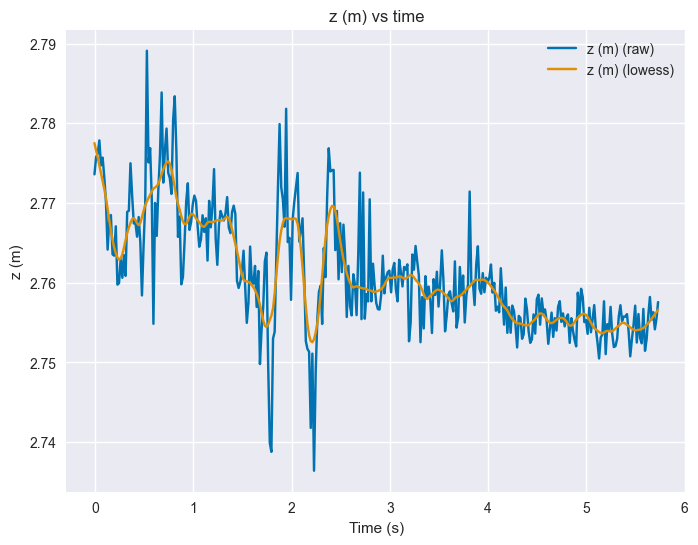

In [70]:
# plot the x and y positions
dim_common_name = {
  "time_norm (sec)": "Time (s)",
  "tx": "x (m)",
  "ty": "y (m)",
  "tz": "z (m)",
  "roll": "roll (degrees)",
  "pitch": "pitch (degrees)",
  "yaw": "yaw (degrees)"
}

def plot_smoothed_data(run: dict, df_name: str, smoothing_types: list[str], x_col: str, y_col: str):
  for smoothing_type in smoothing_types:
    sns.lineplot(data=run[smoothing_type][df_name], x=x_col, y=f"{y_col}",
                 label=f"{dim_common_name[y_col]} ({smoothing_type})")


def plot_all_smoothed_poses(run: dict, df_name, smoothing_types: list[str], x_col: str, columns: list[list[str]], figsize=(30, 15)):
  fig = plt.figure(figsize=figsize)
  # 2 rows, 3 columns
  rows = len(columns)
  cols = len(columns[0])
  flat_columns = np.array(columns).flatten()
  for i, col in enumerate(flat_columns):
    plt.subplot(rows, cols, i + 1)
    plot_smoothed_data(run, df_name, smoothing_types, x_col, col)
    plt.title(f"{dim_common_name[col]} vs time")
    plt.xlabel(dim_common_name[x_col])
    plt.ylabel(dim_common_name[col])
    plt.legend()


plot_all_smoothed_poses(
  run3_data[5],
  "ego_bev_right_df",
  ["raw", "lowess"],
  "time_norm (sec)",
  [["tz"]],
  (8, 6)
)

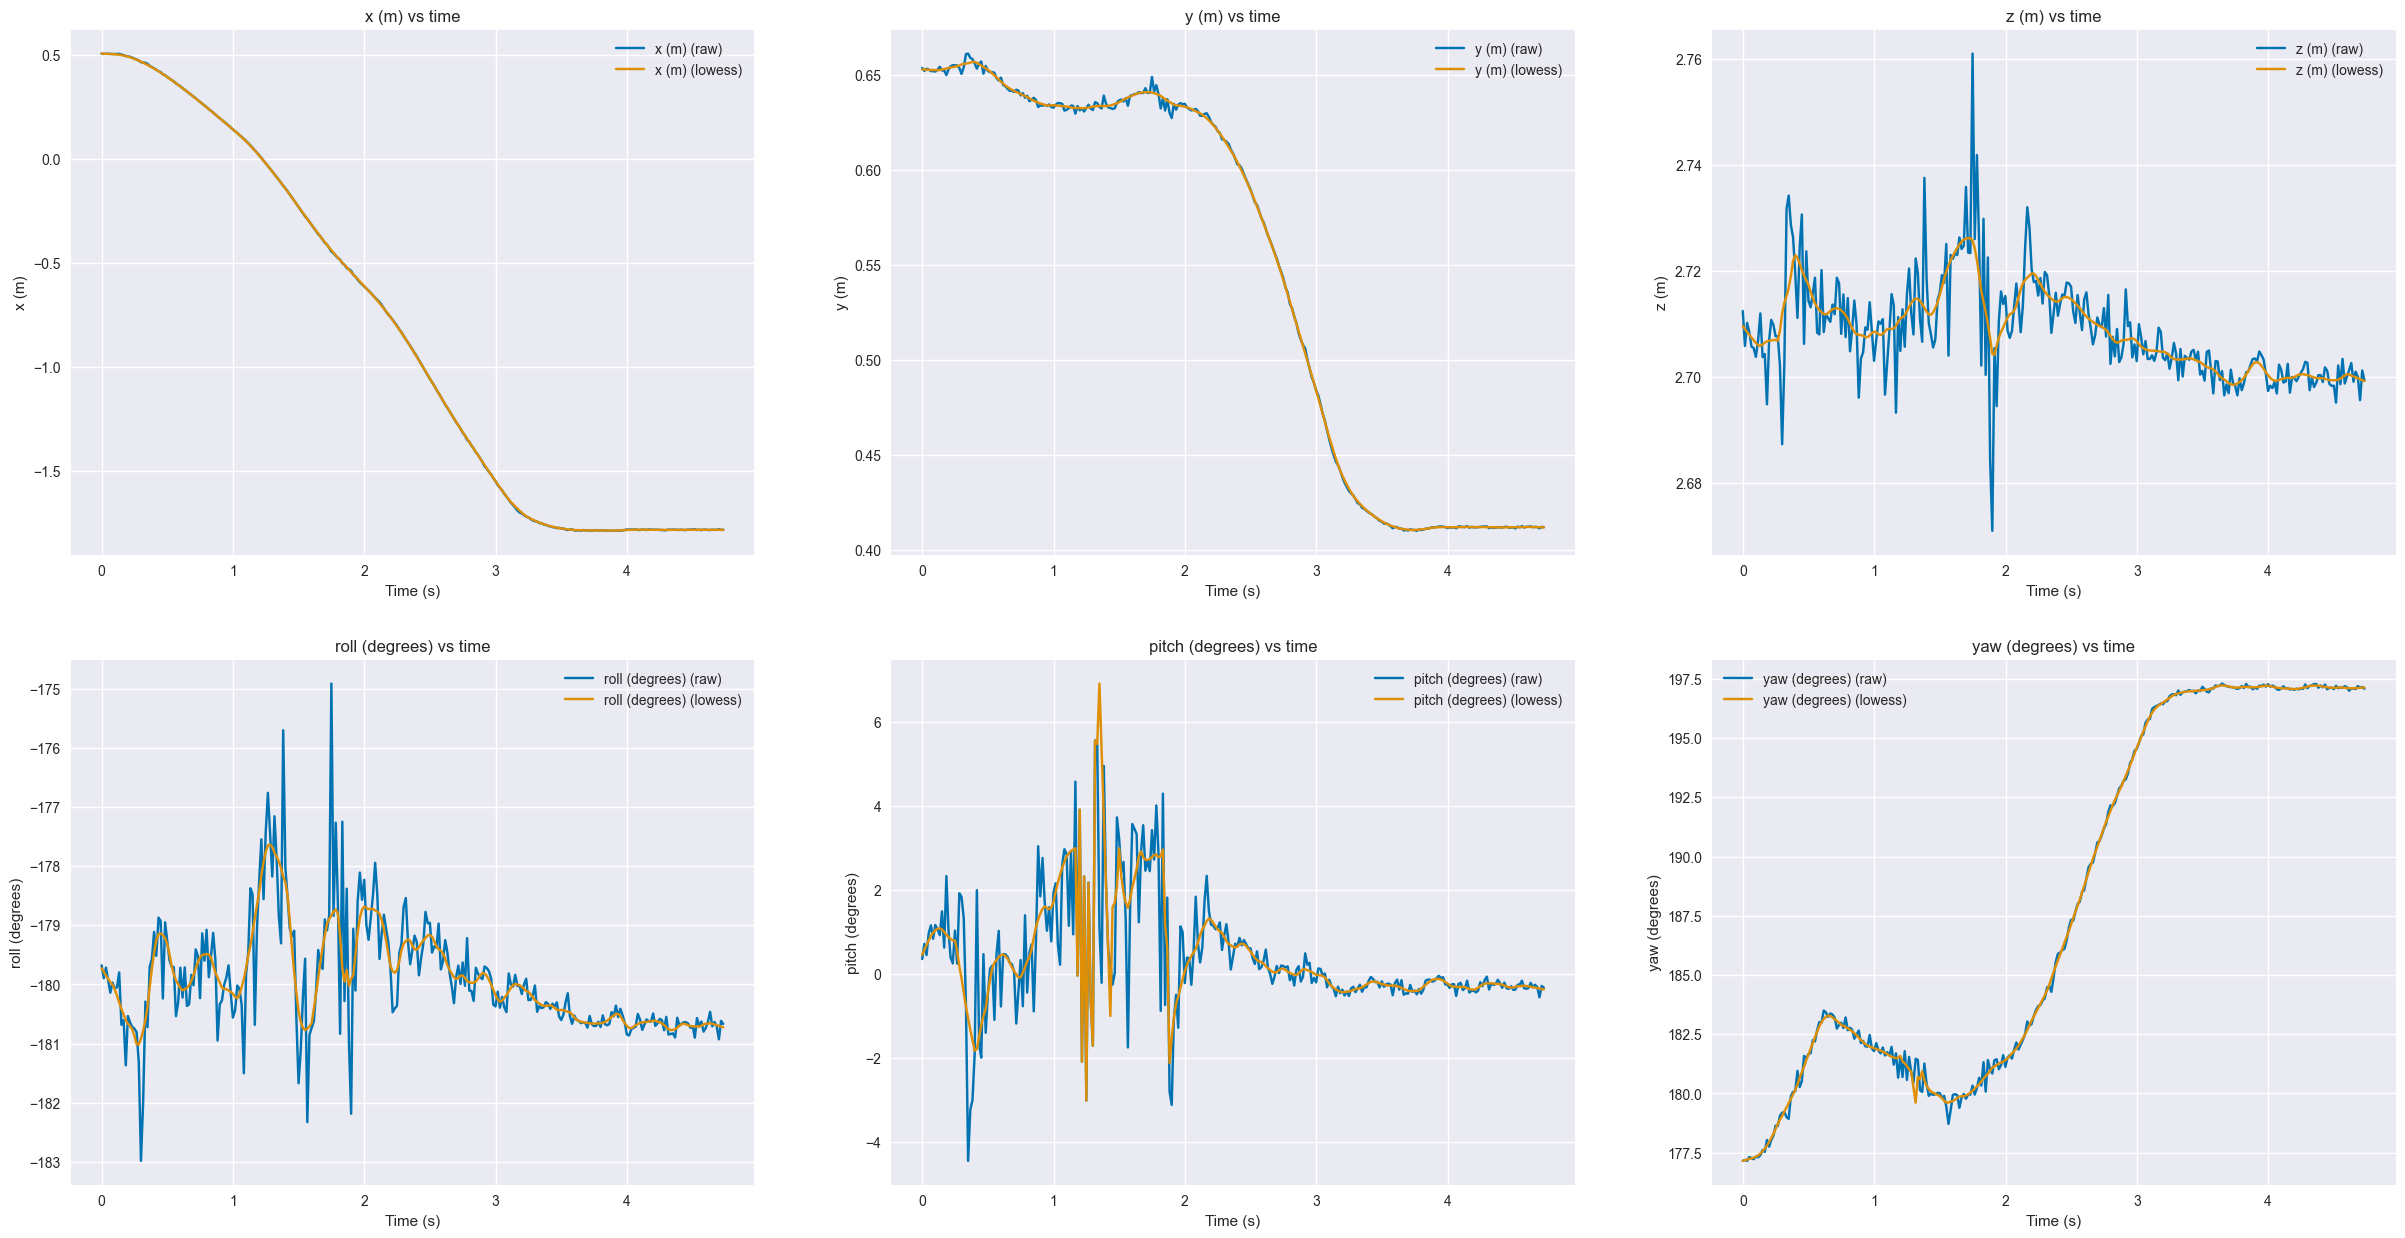

In [121]:
plot_all_smoothed_poses(
  run3_data[6],
  "opp_bev_right_df",
  ["raw", "lowess"],
  "time_norm (sec)",
  [["tx", "ty", "tz"], ["roll", "pitch", "yaw"]]
)

## Plot ground truth relative pose and tracking poses

In [103]:
from perception.scripts import process_state_estimation

importlib.reload(process_state_estimation)

temp = process_state_estimation.StateEstimator(f"{run3_data[6]['ego_path']}", method="kalman_ca_depth_fusion", degrees=True).process()[0]

# turn index into a column
temp.reset_index(inplace=True)
test = temp[temp["time"] > run3_data[6]["kalman_ca_df"]["time"][0]]

run3_data[6]["kalman_ca_depth_fusion_df"] = ground_truth_real.remove_unused_frames(temp, run3_data[6]["start_time"])

Processing: /media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/../../../../perception_debug/run3/ego/24_09_29_23:35:41/color
1 [-0.12230174  0.00921203  1.10225738] [-1.24325737e-01 -5.04510003e-03  1.10259500e+00  1.77965195e+02
  1.78005907e+00  9.00151409e+01] [7.06621542e-01 7.07198406e-01 1.57506211e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.35357146e-02 2.18725817e+00 2.18904377e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1 [-0.12230174  0.00921203  1.10225738] [-1.24325737e-01 -5.04510003e-03  1.10259500e+00  1.77965195e+02
  1.78005907e+00  9.00151409e+01] [-2.72639505e-02  2.96951861e-02  5.26342885e-01 -4.90602190e-02
 -4.52910660e-02  3.50807102e-02 -5.27674722e-03 -4.87135018e-03
  3.77315968e-03  4.46825221e+01  2.08506119e+00  2.42312372e+01
  2.98545164e+00 -6.83186397e-03  1.47351985e+00  3.21104838e-01
 -7.

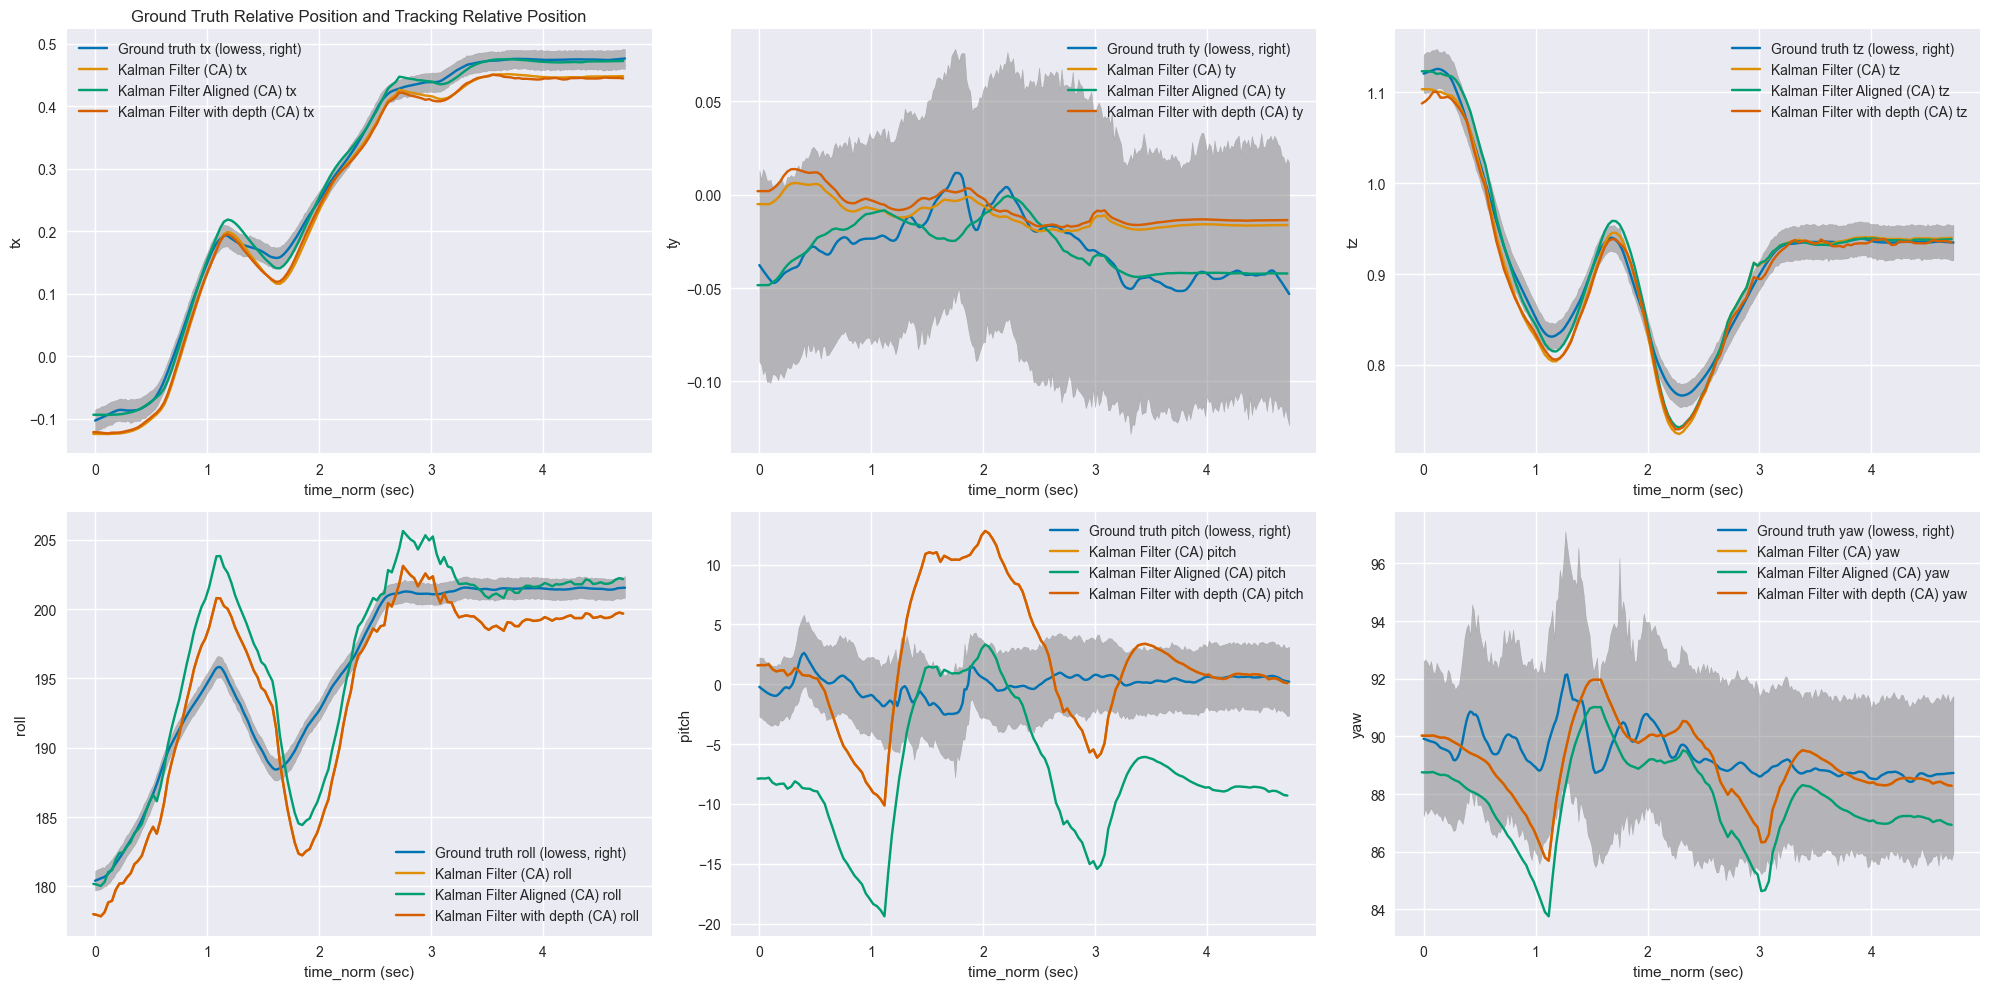

In [60]:
# plot the x and y positions
def plot_relative_position(run: dict, smoothing_type: str, 
  ground_truth_dfs: list[str], uncertainty_method: str, cols: list[list[str]], figsize=(8, 12)):
  plt.figure(figsize=figsize)

  plot_rows = len(cols)
  plot_cols = len(cols[0])
  cols = np.array(cols).flatten()

  for i, col in enumerate(cols):
    ax = plt.subplot(plot_rows, plot_cols, i + 1)
    if i == 0:
      plt.title("Ground Truth Relative Position and Tracking Relative Position")
    
    # Plot ground truth relative positions
    for gt_name in ground_truth_dfs:
      sns.lineplot(data=run[smoothing_type][f"rel_poses_{gt_name}_df"], x="time_norm (sec)", y=col, label=f"Ground truth {col} ({smoothing_type}, {gt_name})")
      # show spline fit for ground truth
      # model, model_deriv, model_2nd_deriv = run[smoothing_type]["spline"][f"rel_poses_{gt_name}_df"][col]
      # sns.lineplot(x=run[smoothing_type][f"rel_poses_{gt_name}_df"]["time_norm (sec)"],
      #              y=model(run[smoothing_type][f"rel_poses_{gt_name}_df"]["time_norm (sec)"]), label=f'Ground truth {col} ({smoothing_type}, spline, {gt_name})')
      
      if uncertainty_method == "tolerance":
        # plot uncertainty from tolerance interval
        plt.fill_between(run[f"monte_carlo_{gt_name}_df"]["time_norm (sec)"], 
                      run[smoothing_type][f"rel_poses_{gt_name}_df"][col] + k * run[f"monte_carlo_{gt_name}_df"][f"{col}_std"],
                      run[smoothing_type][f"rel_poses_{gt_name}_df"][col] - k * run[f"monte_carlo_{gt_name}_df"][f"{col}_std"], color='gray', alpha=0.5)
      elif uncertainty_method == "percentile":
        # plot uncertainty from percentile
        upper_diff = run[f"monte_carlo_{gt_name}_df"][f"{col}_97.5"] - run[f"monte_carlo_{gt_name}_df"][f"{col}_mean"]
        lower_diff = run[f"monte_carlo_{gt_name}_df"][f"{col}_mean"] - run[f"monte_carlo_{gt_name}_df"][f"{col}_2.5"]

        plt.fill_between(run[f"monte_carlo_{gt_name}_df"]["time_norm (sec)"], 
                      run[smoothing_type][f"rel_poses_{gt_name}_df"][col] - lower_diff,
                      run[smoothing_type][f"rel_poses_{gt_name}_df"][col] + upper_diff, color='gray', alpha=0.5)
      
    # Plot state estimation techniques
    # sns.lineplot(data=run["tracking_df"], x="time_norm (sec)", y=col, label=f"PnP {col}")
    sns.lineplot(data=run["kalman_ca_df"], x="time_norm (sec)", y=col, label=f"Kalman Filter (CA) {col}")
    sns.lineplot(data=run["kalman_ca_aligned_df"], x="time_norm (sec)", y=col, label=f"Kalman Filter Aligned (CA) {col}")
    # sns.lineplot(data=run["kalman_cv_df"], x="time_norm (sec)", y=col, label=f"Kalman Filter (CV) {col} ")
    sns.lineplot(data=run["kalman_ca_depth_fusion_df"], x="time_norm (sec)", y=col, label=f"Kalman Filter with depth (CA) {col}")
    # sns.lineplot(data=run["rwr_df"], x="time_norm (sec)", y=col, label=f"Rolling window regression {col}")

  # save plot
  plt.tight_layout()
  # make transparent background
  plt.savefig(f"{figures_dir}/{run['bev_path'].split('/')[-1]}_{smoothing_type}_relative_position.png", transparent=True)

cols = [["tx", "ty", "tz"], ["roll", "pitch", "yaw"]]
plot_relative_position(run3_data[6], "lowess", ["right"], "percentile", cols, figsize=(20, 10))

In [78]:
run2_data[2]["tracking_df"][run2_data[2]["tracking_df"]["time_norm (sec)"] >= 2.1]

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,depth_tx,depth_ty,depth_tz,time (sec),time_norm (sec),roll,pitch,yaw
62,1726393047627511040,0.697089,0.711704,-0.031415,0.080976,2.083794,2.127483,-0.093909,-0.150378,-0.006250,1.645596,-0.138976,-0.003260,1.644226,1.726393e+09,2.124134,-183.959851,9.152376,90.871706
63,1726393047660867584,0.695641,0.708994,-0.055135,0.101844,2.054160,2.093591,-0.162809,-0.156462,0.007756,1.625069,-0.144342,0.010963,1.618214,1.726393e+09,2.157491,-183.733994,12.774942,90.671185
64,1726393047694224128,0.697301,0.714754,-0.024831,0.047759,2.126434,2.179656,-0.075722,-0.162164,0.001799,1.604357,-0.150489,0.004708,1.603202,1.726393e+09,2.190847,-181.792190,5.906211,91.323776
65,1726393047727580928,0.688272,0.710910,0.120921,0.079171,2.059637,2.127381,0.361852,-0.162980,-0.000042,1.559376,-0.153496,0.002319,1.571196,1.726393e+09,2.224204,-196.338924,-3.088902,92.297408
66,1726393047760937472,0.697214,0.715059,-0.023002,0.045314,2.129343,2.183842,-0.070249,-0.171033,0.003790,1.560997,-0.159170,0.006760,1.559184,1.726393e+09,2.257561,-181.744023,5.559430,91.363157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1726393049862416384,0.697051,0.716626,0.018138,0.015440,2.168583,2.229482,0.056429,-0.388180,-0.026192,0.767989,-0.365788,-0.021144,0.748768,1.726393e+09,4.359040,-182.723808,-0.180905,91.590913
130,1726393049895772928,0.696896,0.716845,0.017838,0.012274,2.172420,2.234605,0.055606,-0.387858,-0.025985,0.767245,-0.369362,-0.021201,0.755761,1.726393e+09,4.392396,-182.446305,-0.416247,91.625730
131,1726393049929129728,0.697408,0.716110,0.021061,0.019089,2.164738,2.222791,0.065374,-0.388935,-0.026023,0.769636,-0.371877,-0.021270,0.760756,1.726393e+09,4.425753,-183.255616,-0.116675,91.519409
132,1726393049962486272,0.697751,0.715917,0.018173,0.016611,2.169167,2.225643,0.056495,-0.387716,-0.025774,0.766933,-0.373491,-0.021194,0.763753,1.726393e+09,4.459110,-182.820123,-0.090324,91.474707


## Compute metrics for the runs

### Compute absolute trajectory error (ATE)

In [59]:
def align(model: np.ndarray, gt: np.ndarray):
    """Align two trajectories using the method of Horn (closed-form).
    
    Input:
    model -- first trajectory (3xn)
    gt -- second trajectory (3xn)
    
    Output:
    rot -- rotation matrix (3x3)
    trans -- translation vector (3x1)
    trans_error -- translational error per point (1xn)

    Adapted from: https://github.com/weichnn/Evaluation_Tools/blob/master/ATE-RPE-python/evaluate_ate.py
    
    """
    model_zerocentered = model - model.mean(1).reshape(3, 1)
    data_zerocentered = gt - gt.mean(1).reshape(3, 1)

    # Set the y to zero to prevent alignment in the y direction
    # model_zerocentered[1] = 0
    # data_zerocentered[1] = 0

    W = np.zeros((3, 3))
    for column in range(model.shape[1]):
        W += np.outer(model_zerocentered[:, column], data_zerocentered[:, column])
    U, d, Vh = np.linalg.linalg.svd(W.transpose())
    S = np.matrix(np.identity(3))
    if np.linalg.det(U) * np.linalg.det(Vh) < 0:
        S[2, 2] = -1
    rot = U * S * Vh
    trans = gt.mean(1).reshape(3, 1) - rot * model.mean(1).reshape(3, 1)

    model_aligned = rot * model + trans
    alignment_error = model_aligned - gt
    
    trans_error = np.sqrt(np.sum(np.multiply(alignment_error, alignment_error), 0)).A[0]
    
    return rot, trans, trans_error, model_aligned

def align_trajectory(run, state_est_df_name: str, smoothing_type, model_type, bev_cam):
  state_est_df = run[state_est_df_name]

  state_est_pos = state_est_df[["tx", "ty", "tz"]].values.T
  models = run[smoothing_type][model_type][f"rel_poses_{bev_cam}_df"]

  # for each time step, compute the interpolated pose using the model and create a df
  gt_rel_poses_df = pd.DataFrame()
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    model_func, _, _ = models[dim]
    gt_rel_poses_df[dim] = model_func(state_est_df["time_norm (sec)"])
  gt_rel_poses_df["time_norm (sec)"] = state_est_df["time_norm (sec)"]
  gt = gt_rel_poses_df[["tx", "ty", "tz"]].values.T

  rot, trans, trans_error, _ = align(state_est_pos, gt)

  # Align the translational components
  state_est_aligned_df = state_est_df.copy()
  state_est_aligned_df[["tx", "ty", "tz"]] = (rot @ state_est_pos + trans).T
  
  # Align the rotational components
  state_est_eulers = state_est_aligned_df[["roll", "pitch", "yaw"]].values
  # get rotation matrices from euler angles
  rot_matrices = np.array([conv.get_rotation_matrix_from_euler(*euler, degrees=True) for euler in state_est_eulers])
  # apply the rot to the rot_matrices
  rot_matrices_aligned = np.array([rot @ rot_matrix for rot_matrix in rot_matrices])
  # convert the rotation matrices to euler angles
  eulers_aligned = np.array([conv.get_euler_from_rotation_matrix(rot_matrix, degrees=True) for rot_matrix in rot_matrices_aligned])
  state_est_aligned_df[["roll", "pitch", "yaw"]] = eulers_aligned

  return state_est_df, state_est_aligned_df

state_est_df, state_est_aligned_df = align_trajectory(run3_data[6], "kalman_ca_df", "lowess", "spline", "right")
run3_data[6]["kalman_ca_aligned_df"] = ground_truth_real.correct_euler_offset(
   state_est_aligned_df, run3_data[6]["tracking_df"], ["roll", "pitch", "yaw"])

state_est_df

,time,tx,ty,tz,vx,vy,vz,ax,ay,az,...,pitch,yaw,vroll,vpitch,vyaw,aroll,apitch,ayaw,time (sec),time_norm (sec)
0,1.727606e+18,-0.124474,-0.005013,1.103216,-0.000114,0.000094,0.002266,-0.000151,0.000604,0.005841,...,1.583143,90.026873,-1.347866,0.732036,-0.041992,-2.279486,1.183878,-0.022491,1.727606e+09,-0.016299
1,1.727606e+18,-0.124455,-0.005017,1.103170,0.000033,0.000062,0.001626,0.000356,0.000431,0.003060,...,1.605914,90.023542,-1.479805,0.762820,-0.050020,-2.385597,1.167421,-0.036294,1.727606e+09,0.017035
2,1.727606e+18,-0.124457,-0.005012,1.103300,0.000020,0.000098,0.002223,0.000271,0.000502,0.004708,...,1.590659,90.025829,-1.721768,0.644982,-0.036157,-2.693642,0.870169,-0.007710,1.727606e+09,0.050368
3,1.727606e+18,-0.124541,-0.005089,1.102428,-0.000532,-0.000426,-0.003948,-0.001598,-0.001298,-0.016385,...,1.660072,90.033960,-0.488538,0.853873,-0.000988,-0.184780,1.211289,0.059468,1.727606e+09,0.083701
4,1.727606e+18,-0.124636,-0.004111,1.100104,-0.001098,0.006156,-0.019044,-0.003306,0.020784,-0.064884,...,1.249743,89.993667,2.273915,-0.772478,-0.151824,5.065382,-1.949353,-0.230324,1.727606e+09,0.117034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,1.727606e+18,0.447728,-0.016277,0.938782,0.004128,-0.000039,-0.000331,0.018348,0.001630,0.001679,...,0.502873,88.411538,0.219468,-1.532118,-0.341413,1.134536,-2.296026,-0.295497,1.727606e+09,4.583701
139,1.727606e+18,0.447871,-0.016264,0.939147,0.004711,0.000106,0.002252,0.018251,0.001933,0.010109,...,0.480958,88.428409,0.555001,-1.496855,-0.246874,1.689477,-2.087637,-0.100914,1.727606e+09,4.617034
140,1.727606e+18,0.447968,-0.016256,0.939290,0.004841,0.000188,0.003010,0.016659,0.001992,0.011512,...,0.338598,88.359981,1.277155,-1.904685,-0.473033,2.937926,-2.721842,-0.518656,1.727606e+09,4.650368
141,1.727606e+18,0.448039,-0.016221,0.939522,0.004722,0.000443,0.004242,0.014418,0.002616,0.014330,...,0.151494,88.304723,1.571943,-2.451288,-0.636686,3.308753,-3.580589,-0.794369,1.727606e+09,4.683701


Rotation matrix: [[ 0.99934786  0.01626434  0.03223857]
 [-0.01054193  0.98533317 -0.1703156 ]
 [-0.03453581  0.16986467  0.98486206]]
Translation vector: [[-0.00493722]
 [ 0.13547821]
 [ 0.03365926]]


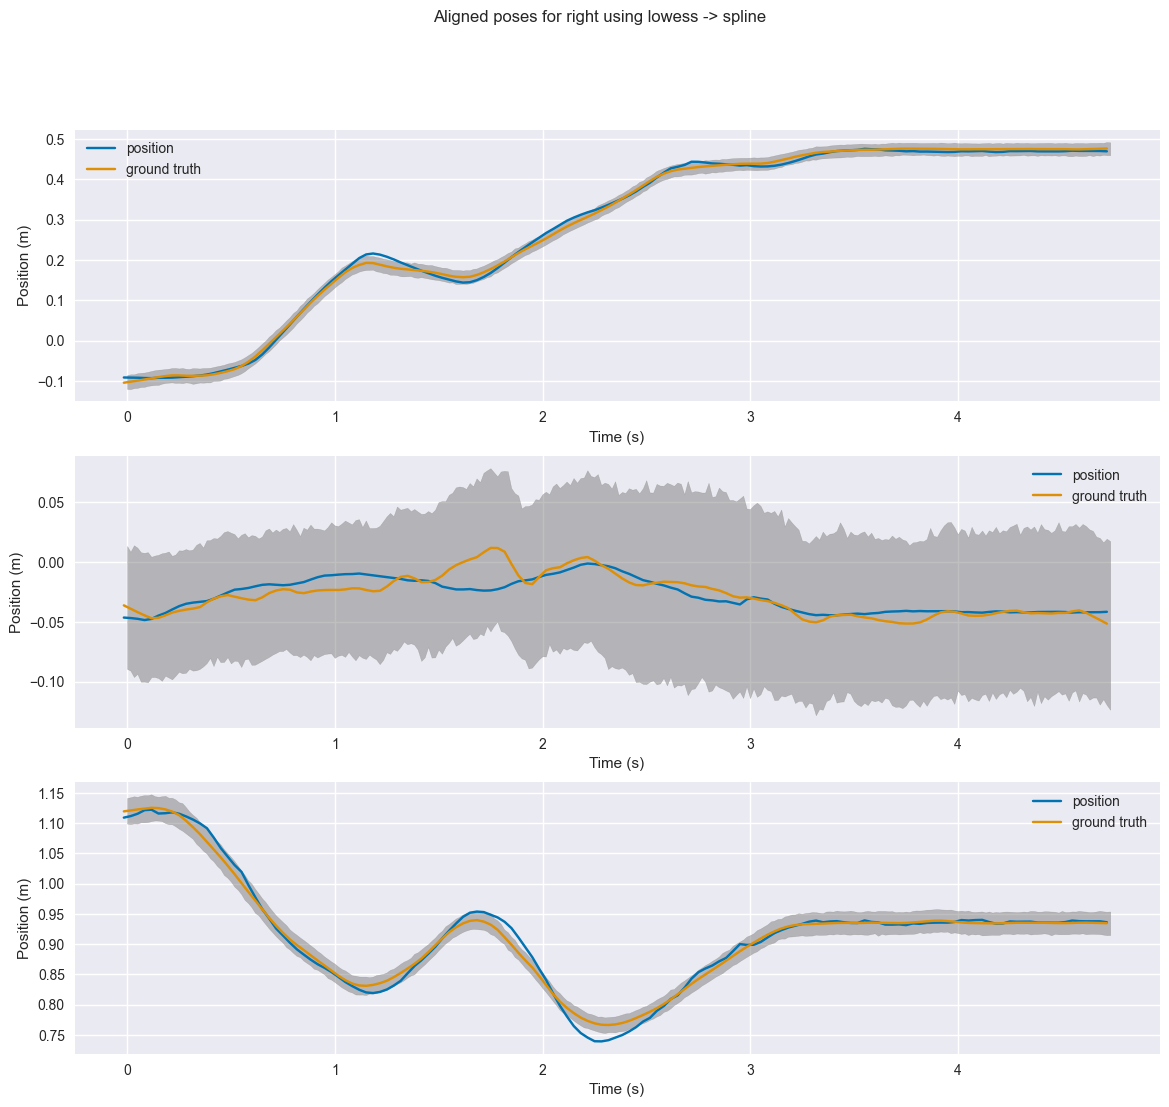

In [118]:
def compute_absolute_trajectory_error(run, smoothing_type: str, model_type:str, 
  bev_cam: str, state_est_df_name: str, uncertainty_method: str, k: float):
  # get the models for x,y,z,roll,pitch,yaw
  models = run[smoothing_type][model_type][f"rel_poses_{bev_cam}_df"]
  # get the state estimation df
  state_est_df: pd.DataFrame = run[state_est_df_name].dropna()
  # for each time step, compute the interpolated pose using the model and create a df
  gt_rel_poses_df = pd.DataFrame()
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    model_func, _, _ = models[dim]
    gt_rel_poses_df[dim] = model_func(state_est_df["time_norm (sec)"])
  gt_rel_poses_df["time_norm (sec)"] = state_est_df["time_norm (sec)"]

  # align the ground truth poses with the state estimation poses
  gt_pos = gt_rel_poses_df[['tx', 'ty', 'tz']].values.T
  est_pos = state_est_df[['tx', 'ty', 'tz']].values.T

  rot, trans, trans_error, model_aligned = align(est_pos, gt_pos)
  # use the rot and trans to transform state_est_df to the same frame as the ground truth
  state_est_df[['tx', 'ty', 'tz']] = np.dot(rot, state_est_df[['tx', 'ty', 'tz']].values.T)

  model_aligned = np.squeeze(np.asarray(model_aligned))
  # plot the aligned poses
  plt.figure(figsize=(14, 12))
  plt.suptitle(f"Aligned poses for {bev_cam} using {smoothing_type} -> {model_type}")
  plt.tight_layout()
  for i, col in enumerate(['tx', 'ty', 'tz']):
    plt.subplot(3, 1, i + 1)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    sns.lineplot(x=state_est_df["time_norm (sec)"], y=model_aligned[i].flatten(), label='position')
    sns.lineplot(x=state_est_df["time_norm (sec)"], y=gt_pos[i].flatten(), label='ground truth')
    upper_diff = run[f"monte_carlo_right_df"][f"{col}_97.5"] - run[f"monte_carlo_right_df"][f"{col}_mean"]
    lower_diff = run[f"monte_carlo_right_df"][f"{col}_mean"] - run[f"monte_carlo_right_df"][f"{col}_2.5"]

    plt.fill_between(run[f"monte_carlo_right_df"]["time_norm (sec)"], 
                  run[smoothing_type][f"rel_poses_right_df"][col] - lower_diff,
                  run[smoothing_type][f"rel_poses_right_df"][col] + upper_diff, color='gray', alpha=0.5)
  
  print(f"Rotation matrix: {rot}")
  print(f"Translation vector: {trans}")
  # print(f"Translational error: {trans_error}")

compute_absolute_trajectory_error(run3_data[6], "lowess", "spline", "right", "kalman_ca_depth_fusion_df", "percentile", k)

### Compute relative pose error

In [217]:
def compute_relative_pose_error(run, smoothing_type: str, model_type:str, 
  bev_cam: str, state_est_df_name: str, index_offset: int, uncertainty_method: str, k: float):
  """
  Compute the relative pose error between the ground truth and state estimation

  Adapted from: https://github.com/weichnn/Evaluation_Tools/blob/master/ATE-RPE-python/evaluate_rpe.py

  Original paper: https://gki.informatik.uni-freiburg.de/papers/burgard_et_al_iros09.pdf
  """

  # get the models for x,y,z,roll,pitch,yaw
  models = run[smoothing_type][model_type][f"rel_poses_{bev_cam}_df"]
  # get the state estimation df
  state_est_df = run[state_est_df_name].dropna()
  # for each time step, compute the interpolated pose using the model and create a df
  gt_poses_df = pd.DataFrame()
  gt_poses_diff_df = pd.DataFrame()
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    model_func, _, _ = models[dim]
    gt_poses_df[dim] = model_func(state_est_df["time_norm (sec)"])

  state_est_diff_df = pd.DataFrame()
  gt_poses_diff_df["time_norm (sec)"] = state_est_df["time_norm (sec)"]
  state_est_diff_df["time_norm (sec)"] = state_est_df["time_norm (sec)"]

  results = []
  for i in range(index_offset, len(gt_poses_df)):
    gt_rot_curr = conv.get_rotation_matrix_from_euler(
      gt_poses_df.loc[i, "roll"], 
      gt_poses_df.loc[i, "pitch"], 
      gt_poses_df.loc[i, "yaw"], degrees=True
    )
    gt_rot_prev = conv.get_rotation_matrix_from_euler(
      gt_poses_df.loc[i - index_offset, "roll"], 
      gt_poses_df.loc[i - index_offset, "pitch"], 
      gt_poses_df.loc[i - index_offset, "yaw"], degrees=True
    )

    state_est_rot_curr = conv.get_rotation_matrix_from_euler(
      state_est_df.loc[i, "roll"], 
      state_est_df.loc[i, "pitch"], 
      state_est_df.loc[i, "yaw"], degrees=True
    )

    state_est_rot_prev = conv.get_rotation_matrix_from_euler(
      state_est_df.loc[i - index_offset, "roll"], 
      state_est_df.loc[i - index_offset, "pitch"], 
      state_est_df.loc[i - index_offset, "yaw"], degrees=True
    )
    # Get the ground truth and state estimation positions
    gt_pos_curr = np.array([gt_poses_df.loc[i, "tx"], gt_poses_df.loc[i, "ty"], gt_poses_df.loc[i, "tz"]])
    gt_pos_prev = np.array([gt_poses_df.loc[i - index_offset, "tx"], gt_poses_df.loc[i - index_offset, "ty"], gt_poses_df.loc[i - index_offset, "tz"]])
    state_est_pos_curr = np.array([state_est_df.loc[i, "tx"], state_est_df.loc[i, "ty"], state_est_df.loc[i, "tz"]])
    state_est_pos_prev = np.array([state_est_df.loc[i - index_offset, "tx"], state_est_df.loc[i - index_offset, "ty"], state_est_df.loc[i - index_offset, "tz"]])

    # get the relative transform between two consecutive time steps for both ground truth and state estimation
    gt_rel_pos, gt_rel_rot = gt_pos_curr - gt_pos_prev, gt_rot_prev.T @ gt_rot_curr
    state_est_rel_pos, state_est_rel_rot = state_est_pos_curr - state_est_pos_prev, state_est_rot_prev.T @ state_est_rot_curr
    
    # get the error for the relative transform of state estimation compared to ground truth
    gt_est_rel_rot = state_est_rel_rot.T @ gt_rel_rot
    gt_est_rel_pos = gt_rel_pos - state_est_rel_pos

    distance = np.linalg.norm(gt_est_rel_pos)
    angle_deg = np.arccos(min(1, max(-1, (np.trace(gt_est_rel_rot) - 1) / 2))) * 180 / np.pi

    results.append({
      "time_norm (sec)": state_est_df.loc[i, "time_norm (sec)"],
      "gt_rel_pos": gt_rel_pos,
      "gt_rel_rot": gt_rel_rot,
      "state_est_rel_pos": state_est_rel_pos,
      "state_est_rel_rot": state_est_rel_rot,
      "distance": distance,
      "angle": angle_deg,
    })
  return results

rel_pose_error = compute_relative_pose_error(
  run3_data[4], "raw", "pchip", "right", "rwr_df", 10, "tolerance", k
)

<AxesSubplot: xlabel='Time (s)', ylabel='Angle (degrees)'>

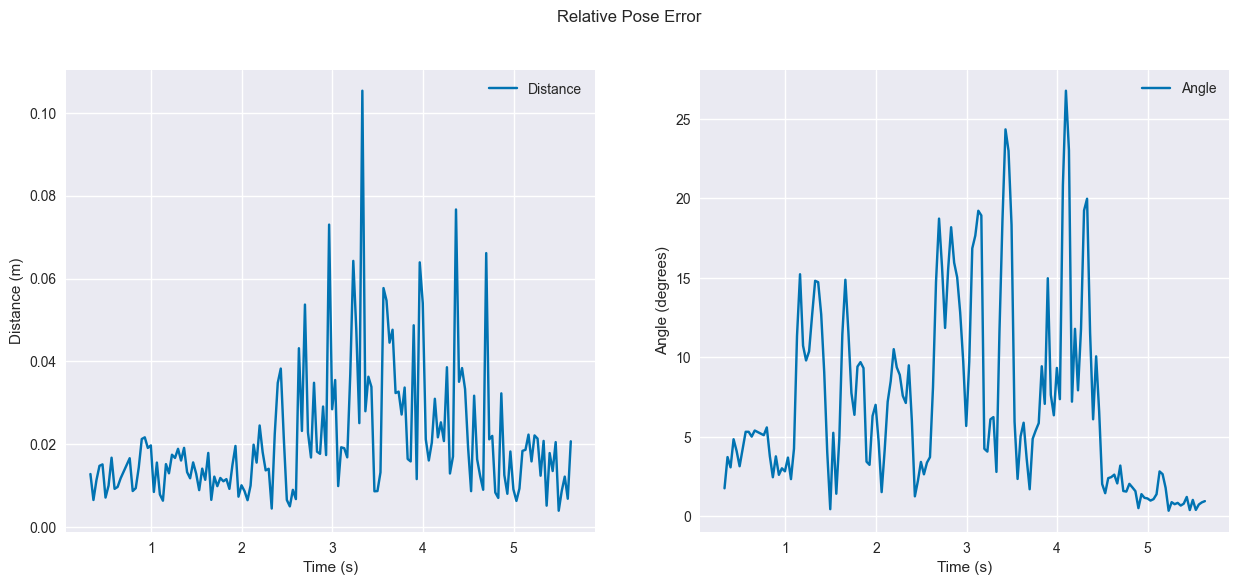

In [218]:
rel_pose_error_df = pd.DataFrame(rel_pose_error)
plt.figure(figsize=(15, 6))
plt.suptitle("Relative Pose Error")
plt.subplot(1, 2, 1)
plt.ylabel("Distance (m)")
plt.xlabel("Time (s)")
sns.lineplot(data=rel_pose_error_df, x="time_norm (sec)", y="distance", label="Distance")
plt.subplot(1, 2, 2)
plt.ylabel("Angle (degrees)")
plt.xlabel("Time (s)")
sns.lineplot(data=rel_pose_error_df, x="time_norm (sec)", y="angle", label="Angle")

### Proportion of data that is within the tolerance interval

In [219]:
def compute_proportion_within_interval(run, smoothing_type: str, model_type:str, 
  cam: str, state_est_df: str, col: str, uncertainty_method: str, k: float):
  
  gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][col][0]
  mc_df = run[f"monte_carlo_{cam}_df"]

  # iterate through the state estimation data
  state_est_data = run[state_est_df]
  num_within_interval = 0
  for i, row in state_est_data.iterrows():
    # get index of the closest time step from the monte carlo data
    idx = np.argmin(np.abs(mc_df["time_norm (sec)"] - row["time_norm (sec)"]))
    norm_time = mc_df["time_norm (sec)"][idx]
    if uncertainty_method == "percentile":
      lower_diff = mc_df[f"{col}_mean"][idx] - mc_df[f"{col}_2.5"][idx]
      upper_diff = mc_df[f"{col}_97.5"][idx] - mc_df[f"{col}_mean"][idx]

      lower_bound = gt_model(norm_time) - lower_diff
      upper_bound = gt_model(norm_time) + upper_diff
    elif uncertainty_method == "tolerance":
      lower_bound = gt_model(norm_time) - k * mc_df[f"{col}_std"][idx]
      upper_bound = gt_model(norm_time) + k * mc_df[f"{col}_std"][idx]
    if row[col] >= lower_bound and row[col] <= upper_bound:
      num_within_interval += 1
  
  return num_within_interval / len(state_est_data)

compute_proportion_within_interval(run3_data[6], "raw", "pchip",
                                    "right", "kalman_ca_df", "tx", "tolerance", k)

0.18181818181818182

### Pearson correlation coefficient

In [220]:
def compute_pearson_correlation(run, smoothing_type: str, model_type: str, cam: str,
                                 state_est_df: str, dim: str, deriv: int):
  gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][dim][deriv]
  
  if dim.startswith("t"):
    dim = dim[1:]

  if deriv == 0:
    if dim not in ("roll", "pitch", "yaw"):
      dim = f"t{dim}"
  elif deriv == 1:
    dim = f"v{dim}"
  else:
    dim = f"a{dim}"
    
  state_est_data = run[state_est_df]
  # get predicted values for the state estimation data
  gt_data = pd.DataFrame([{"time_norm (sec)": t, dim: float(gt_model(t))}\
                           for t in state_est_data["time_norm (sec)"]])
  return state_est_data[dim].corr(gt_data[dim])

compute_pearson_correlation(run3_data[6], "lowess", "spline", "right", "kalman_ca_df", "tx", 0), \
compute_pearson_correlation(run3_data[6], "raw", "pchip", "right", "kalman_ca_df", "tx", 0)

(0.99206834835078, 0.9944036478617099)

### MSE and RMSE (with ground truth uncertainty)

In [10]:
# load splines from pkl
def load_splines(path, cam):
  """
  For each of the 1000 simulations, we load the 6 splines for each dimension
  and their derivatives.
  """
  splines = []
  for i in range(1000):
    splines.append(pickle.load(open(f"{path}/bev/{cam}/monte_carlo_splines/splines_{i}.pkl", "rb")))
  spline_derivs = [list(map(lambda x: x.derivative(), spline)) for spline in splines]
  spline_2nd_derivs = [list(map(lambda x: x.derivative(), spline)) for spline in spline_derivs]
  return splines, spline_derivs, spline_2nd_derivs

def compute_monte_carlo_vals(splines, eval_times: np.ndarray):
  """
  For each of the 1000 simulations, evaluate the splines
  for each of the 6 dimensions at every time step in eval_times

  This ensure that the time steps are consistent with the data frame we want to evaluate
  """
  monte_carlo_vals = []
  for i in range(1000):
    monte_carlo_vals.append(np.array([splines[i][j](eval_times) for j in range(6)]).T)
  return monte_carlo_vals

def get_distribution_stats(monte_carlo_vals):
  """
  Get the mean, standard deviation and 95% prediction interval for the quantities
  (position, velocity, acceleration) for each of the 6 dimensions
  """
  poses = np.array(monte_carlo_vals)
  pose_mean = np.mean(poses, axis=0)
  pose_std = np.std(poses, axis=0, ddof=1)
  pose_95 = np.percentile(poses, [2.5, 97.5], axis=0)

  return pose_mean, pose_std, pose_95

In [67]:
all_dims = ["tx", "ty", "tz", "roll", "pitch", "yaw"]

def get_quantity_name(dim: str, deriv: Literal["position", "velocity", "acceleration"]):
  """
  Get the name of the quantity based on the dimension and the derivative type
  """
  if dim.startswith("t"):
    dim = dim[1:]

  if deriv == "position":
    if dim not in ("roll", "pitch", "yaw"):
      dim = f"t{dim}"
  elif deriv == "velocity":
    dim = f"v{dim}"
  else:
    dim = f"a{dim}"
  return dim

def get_derivative_num(deriv: Literal["position", "velocity", "acceleration"]):
  if deriv == "position":
    return 0
  elif deriv == "velocity":
    return 1
  else:
    return 2

def compute_mse(run, smoothing_type: str, model_type: str, cam: str, state_est_df: str, dim: str, deriv: Literal["position", "velocity", "acceleration"]):
  gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][dim][get_derivative_num(deriv)]
  
  deriv_dim = get_quantity_name(dim, deriv)
  state_est_data = run[state_est_df]

  # get predicted values for the state estimation data
  gt_data = pd.DataFrame([{"time_norm (sec)": t, dim: float(gt_model(t))}\
                           for t in state_est_data["time_norm (sec)"]])
  return np.mean((state_est_data[deriv_dim] - gt_data[deriv_dim])**2)

def compute_rmse(run, smoothing_type: str, model_type: str, cam: str, state_est_df: str, dim: str, deriv: int):
  return np.sqrt(compute_mse(run, smoothing_type, model_type, cam, state_est_df, dim, deriv))
  
def compute_mse_with_ground_truth_uncertainty(run, all_splines, smoothing_type: str, model_type: str, cam: str,
    state_est_df_name: str, dims: list[str], deriv: Literal["position", "velocity", "acceleration"], uncertainty_method: str, 
    k: float=twoside.normal_factor(1000, 0.95, 0.95)):
  """
  Compute the mean squared error between the state estimation data and the ground truth model
  taking into account the uncertainty from the Monte Carlo simulations

  Args:
  run: dict -- the run data
  all_splines: tuple -- the splines, spline derivatives and 2nd derivatives for all the Monte Carlo simulations
  smoothing_type: str -- the type of smoothing used for the ground truth
  model_type: str -- the type of model used for the ground truth
  cam: str -- the camera name
  state_est_df_name: str -- the name of the state estimation data frame to evaluate
  dims: list[str] -- the dimensions to evaluate
  deriv: Literal["position", "velocity", "acceleration"] -- the derivative to evaluate
  uncertainty_method: str -- the method to use for uncertainty (percentile or tolerance)
  k: float -- the factor to use for the tolerance interval

  Returns:
  dict -- the mean squared error for each dimension
  """  
  deriv_dims = [get_quantity_name(dim, deriv) for dim in dims]
    
  mc_df = run[f"monte_carlo_{cam}_df"]
  state_est_data = run[state_est_df_name]
  mses = defaultdict(float)
  non_nan_counts = defaultdict(int)
  if deriv == "position":

    for i, row in state_est_data.iterrows():
      # Get index of the closest time step from the Monte Carlo data
      idx = np.argmin(np.abs(mc_df["time_norm (sec)"] - row["time_norm (sec)"]))
      norm_time = mc_df["time_norm (sec)"][idx]
      for deriv_dim, dim in zip(deriv_dims, dims):
        gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][dim][get_derivative_num(deriv)]

        if uncertainty_method == "percentile":
          lower_diff = mc_df[f"{deriv_dim}_mean"][idx] - mc_df[f"{dim}_2.5"][idx]
          upper_diff = mc_df[f"{deriv_dim}_97.5"][idx] - mc_df[f"{dim}_mean"][idx]

          lower_bound = gt_model(norm_time) - lower_diff
          upper_bound = gt_model(norm_time) + upper_diff
        elif uncertainty_method == "tolerance":
          
          if np.isnan(mc_df[f"{dim}_std"][idx]):
            continue
          lower_bound = gt_model(norm_time) - k * mc_df[f"{deriv_dim}_std"][idx]
          upper_bound = gt_model(norm_time) + k * mc_df[f"{deriv_dim}_std"][idx]
        
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}, State estimation: {row[deriv_dim]}")
        # get maximum difference between bounds and the state estimation value
        mses[deriv_dim] += max(
          max(row[deriv_dim] - upper_bound, 0),
          max(lower_bound - row[deriv_dim], 0)
        ) ** 2
        print(max(
          max(row[deriv_dim] - upper_bound, 0),
          max(lower_bound - row[deriv_dim], 0)
        ))
        non_nan_counts[deriv_dim] += 1

    return {dim: mses[dim] / non_nan_counts[dim] for dim in deriv_dims}
  
  else:
    splines, spline_derivs, spline_2nd_derivs = all_splines
    eval_times = state_est_data["time_norm (sec)"].values

    if deriv == "velocity":
      monte_carlo_vals = compute_monte_carlo_vals(spline_derivs, eval_times)
    else:
      monte_carlo_vals = compute_monte_carlo_vals(spline_2nd_derivs, eval_times)

    # Get the Monte Carlo distributions for each time step in eval_times
    pose_mean, pose_std, pose_95 = get_distribution_stats(monte_carlo_vals)
    if uncertainty_method == "percentile":
      for dim, deriv_dim in zip(dims, deriv_dims):
        gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][dim][get_derivative_num(deriv)]

        upper_diff = pose_95[1, :, all_dims.index(dim)] - pose_mean[:, dims.index(dim)]
        lower_diff = pose_mean[:, dims.index(dim)] - pose_95[0, :, dims.index(dim)]

        gt_model_vals = np.array([gt_model(t) for t in eval_times])
        gt_model_upper_vals = gt_model_vals + upper_diff
        gt_model_lower_vals = gt_model_vals - lower_diff
  
        mses[deriv_dim] = np.mean(np.maximum(
          np.maximum(gt_model_lower_vals - state_est_data[deriv_dim].values, 0),
          np.maximum(state_est_data[deriv_dim].values - gt_model_upper_vals, 0)) ** 2
        )

        print((np.maximum(
          np.maximum(gt_model_lower_vals - state_est_data[deriv_dim].values, 0),
          np.maximum(state_est_data[deriv_dim].values - gt_model_upper_vals, 0)) ** 2)[3],
          gt_model_lower_vals[3], gt_model_upper_vals[3], state_est_data[deriv_dim].values[3])
       
      return mses
    else:
      raise ValueError("Uncertainty method not implemented")

def compute_rmse_with_ground_truth_uncertainty(run, all_splines, smoothing_type: str, model_type: str, cam: str,
    state_est_df_name: str, dims: list[str], deriv: Literal["position", "velocity", "acceleration"], uncertainty_method: str, 
    k: float=twoside.normal_factor(1000, 0.95, 0.95)):
  """
  Compute the root mean squared error between the state estimation data and the ground truth model
  taking into account the uncertainty from the Monte Carlo simulations
  """
  mses = compute_mse_with_ground_truth_uncertainty(run, all_splines, smoothing_type, model_type, cam, state_est_df_name, dims, deriv, uncertainty_method, k)
  return {dim: np.sqrt(mses[dim]) for dim in mses}

state_est_method = "kalman_ca_df"
run = run2_data[6]

all_splines = load_splines(run["bev_path"], "right")

compute_rmse_with_ground_truth_uncertainty(run, all_splines, "lowess", "spline", "right",
                                            state_est_method, ["tx", "tz", "roll"], "velocity", "percentile")

0.0 -0.07950026419668062 0.10243380463071507 -7.855945589508098e-05
0.0 -0.18766611139493733 0.06157598483885471 0.0070315515782308
0.1806011353781096 0.7657667638514798 4.515724918570298 0.340794840804663


{'vx': 0.08824944778055749,
 'vz': 0.3833741597252347,
 'vroll': 7.567121189352056}

## Plot BEV relative velocity models and estimated relative velocity from egovehicle

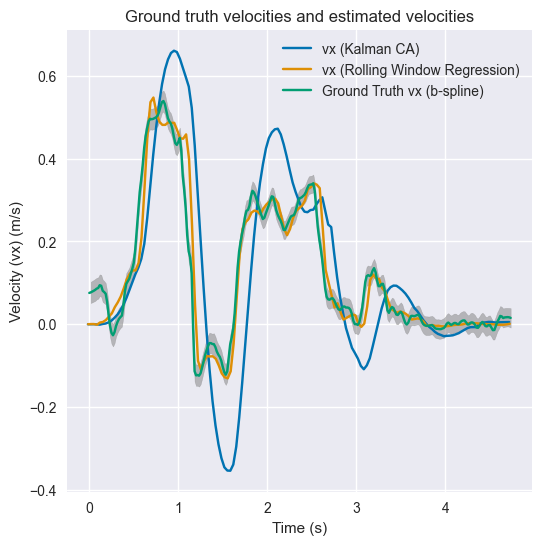

In [119]:
smoothing_type = "lowess"
run_num = 6
run = run3_data[run_num]
rel_poses_df_name = "rel_poses_right_df"
monte_carlo_df_name = "monte_carlo_right_df"

def plot_velocity(run: dict, smoothing_type: str, monte_carlo_df: str, rel_poses_df: str,
                   col: str, vel_col: str, figsize=(20, 20)):
  plt.figure(figsize=figsize)

  plt.title("Ground truth velocities and estimated velocities")
  plt.xlabel("Time (s)")
  plt.ylabel(f"Velocity ({vel_col}) (m/s)")

  # Use uncertainty propagation from the monte carlo to get uncertainty for velocity
  vel_error = run[monte_carlo_df].copy()
  for c in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    vel_error[f"{c}_std"] = np.sqrt(run[monte_carlo_df][f"{c}_std"] ** 2 \
                                    + run[monte_carlo_df][f"{c}_std"].shift(1) ** 2)
  spline_tx, spline_vx, spline_ax = run[smoothing_type]["spline"][rel_poses_df][col]

  spline_vx_vals = spline_vx(run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"])
  spline_first_zero = min(np.argmax(spline_vx_vals > 0), np.argmax(spline_vx_vals < 0))

  ### PLOT THE STATE ESTIMATION TECHNIQUES ###
  sns.lineplot(data=run["kalman_ca_df"], x="time_norm (sec)", y=vel_col, label=f"{vel_col} (Kalman CA)")
  # sns.lineplot(data=run["kalman_cv_df"], x="time_norm (sec)", y=vel_col, label=f"{vel_col} (Kalman CV)")
  sns.lineplot(data=run["rwr_df"], x="time_norm (sec)", y=vel_col, label=f"{vel_col} (Rolling Window Regression)")

  ### PLOT THE GROUND TRUTHS ###
  # sns.lineplot(x=run[smoothing_type][rel_poses_df]["time_norm (sec)"].iloc[poly_first_zero:], 
  #              y=poly_vx_vals[poly_first_zero:], label=f'{vel_col} (poly)')
  # plt.fill_between(run[monte_carlo_df]["time_norm (sec)"].iloc[poly_first_zero:],
  #                 poly_vx_vals[poly_first_zero:] + k * vel_error[f"{col}_std"].iloc[poly_first_zero:],
  #                 poly_vx_vals[poly_first_zero:] - k * vel_error[f"{col}_std"].iloc[poly_first_zero:], color='gray', alpha=0.5)
  sns.lineplot(x=run[smoothing_type][rel_poses_df]["time_norm (sec)"].iloc[spline_first_zero:],
               y=spline_vx_vals[spline_first_zero:], label=f"Ground Truth {vel_col} (b-spline)")
  plt.fill_between(run[monte_carlo_df]["time_norm (sec)"].iloc[spline_first_zero:],
                  spline_vx_vals[spline_first_zero:] + k * vel_error[f"{col}_std"].iloc[spline_first_zero:],
                  spline_vx_vals[spline_first_zero:] - k * vel_error[f"{col}_std"].iloc[spline_first_zero:], color='gray', alpha=0.5)
  # sns.lineplot(x=run[smoothing_type][rel_poses_df]["time_norm (sec)"],
  #               y=pchip_vx(run[smoothing_type][rel_poses_df]["time_norm (sec)"]), label=f'v_x ({smoothing_type} -> pchip)')

  plt.savefig(f"{figures_dir}/{run['bev_path'].split('/')[-1]}_{smoothing_type}_relative_velocity_{vel_col}.png", transparent=True)
  
plot_velocity(run, smoothing_type, monte_carlo_df_name,
  rel_poses_df_name, "tx", "vx", (6, 6))

0
2
3


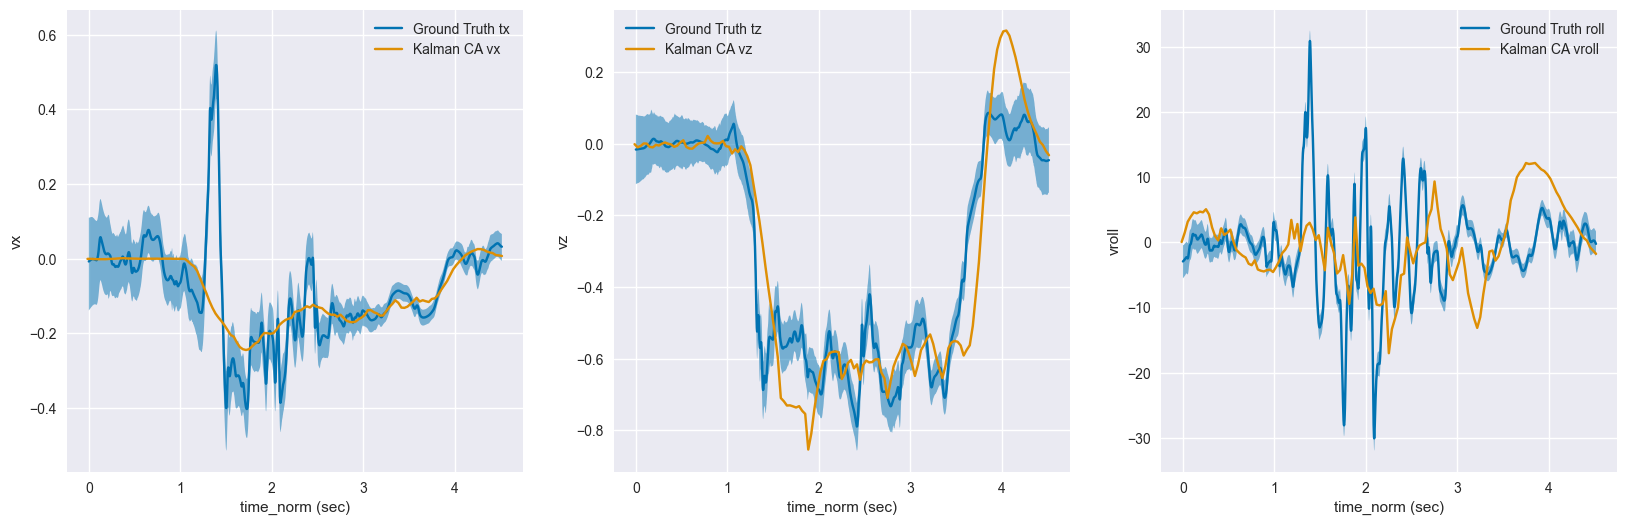

In [64]:
run_num = 2
cam = 'right'
run = run2_data[run_num]

dims = ["tx", "ty", "tz", "roll", "pitch", "yaw"]

def get_quantity_name(dim: str, deriv: Literal["position", "velocity", "acceleration"]):
  """
  Get the name of the quantity based on the dimension and the derivative type
  """
  if dim.startswith("t"):
    dim = dim[1:]

  if deriv == "position":
    if dim not in ("roll", "pitch", "yaw"):
      dim = f"t{dim}"
  elif deriv == "velocity":
    dim = f"v{dim}"
  else:
    dim = f"a{dim}"
  return dim

def get_derivative_num(deriv: Literal["position", "velocity", "acceleration"]):
  if deriv == "position":
    return 0
  elif deriv == "velocity":
    return 1
  else:
    return 2

# plot the velocity with prediction interval
def plot_velocity_with_prediction_interval(run, all_splines, smoothing_type: str, model_type: str,
  deriv: Literal["position", "velocity", "acceleration"], cols: list[list[str]], figsize=(20, 10)):

  state_est_dfs = [run["kalman_cv_df"], run["kalman_ca_df"], run["rwr_df"]]
  
  # Get the maximum time_norm (sec) for the state estimation data
  max_time = max([df["time_norm (sec)"].max() for df in state_est_dfs])
  eval_times = np.arange(0, max_time, 0.001)

  splines, spline_derivs, spline_2nd_derivs = all_splines
 
  if deriv == "position":
    monte_carlo_vals = compute_monte_carlo_vals(splines, eval_times)
  elif deriv == "velocity":
    monte_carlo_vals = compute_monte_carlo_vals(spline_derivs, eval_times)
  else:
    monte_carlo_vals = compute_monte_carlo_vals(spline_2nd_derivs, eval_times)

  # Get the Monte Carlo distributions for each time step in eval_times
  pose_mean, pose_std, pose_95 = get_distribution_stats(monte_carlo_vals)
  
  plot_rows = len(cols)
  plot_cols = len(cols[0])
  cols = np.array(cols).flatten()
  deriv_cols = [get_quantity_name(c, deriv) for c in cols]
  
  plt.figure(figsize=figsize)

  for i, (col, deriv_col) in enumerate(zip(cols, deriv_cols)):
    ax = plt.subplot(plot_rows, plot_cols, i + 1)

    # Get the ground truth spline
    spline = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][col][get_derivative_num(deriv)]
    spline_vals = spline(eval_times)
    print(dims.index(col))
    upper_diff = pose_95[1, :, dims.index(col)] - pose_mean[:, dims.index(col)]
    lower_diff = pose_mean[:, dims.index(col)] - pose_95[0, :, dims.index(col)]

    # PLOT GROUND TRUTH
    sns.lineplot(x=eval_times, y=spline_vals, ax=ax, label=f"Ground Truth {col}")

    # PLOT STATE ESTIMATION
    sns.lineplot(x=run["kalman_ca_df"]["time_norm (sec)"], y=run["kalman_ca_df"][deriv_col],
                  ax=ax, label=f"Kalman CA {deriv_col}")
    # sns.lineplot(x=run["kalman_cv_df"]["time_norm (sec)"], y=run["kalman_cv_df"][deriv_col],
    #               ax=ax, label=f"Kalman CV {deriv_col}")
    # sns.lineplot(x=run["rwr_df"]["time_norm (sec)"], y=run["rwr_df"][deriv_col],
    #               ax=ax, label=f"Rolling Window Regression {deriv_col}")

    plt.fill_between(eval_times, spline_vals - lower_diff, spline_vals + upper_diff, alpha=0.5)


# get_single_simulation_stats(monte_carlo_vel, 25)
all_splines = load_splines(run["bev_path"], cam)
plot_velocity_with_prediction_interval(run, all_splines, "lowess", "spline", "velocity", [["tx", "tz", "roll"]], figsize=(20, 6))